[link for paper](https://www-nature-com.libproxy1.nus.edu.sg/articles/s41588-018-0295-5)
[link for code](https://github.com/OSU-BMBL/BMI8050-2020/blob/master/4_cnn_example/example_cnn.ipynb)

# 0. Background
- DL approach in the discovery of TF binding sites in DNA
- based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not
- The longer DNA sequences are our *independent variables* (*predictors*), while the positive or negative response of the assay is the *dependent variable* (*response*)
- Use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with)
- labeled with 0 or 1 depending on the results of the assay
- Goal: Build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein

# 1. Curate the data
<img src = 'https://camo.githubusercontent.com/d2133268c37bdf854346eba229418003fc476428/68747470733a2f2f6769746875622e636f6d2f616269646c6162732f646565702d6c6561726e696e672d67656e6f6d6963732d7072696d65722f626c6f622f6d61737465722f53637265656e73686f7425323066726f6d253230323031382d30382d303125323032302d33312d30312e706e673f7261773d74727565'>



In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


In [90]:
# one-hot encoding sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# LabelEncoder: encodes a sequence of bases as a sequence of integers
integer_encoder = LabelEncoder()

# OneHotEncoder: converts an array of integers to a sparse matrix where
# each row corresponds to one possible value of each feature
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []
input_features_2d = []
for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  input_features_2d.append(integer_encoded.flatten())
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
input_features_2d = np.stack(input_features_2d)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)
print('Integer encoding of Sequence #1:\n',input_features_2d[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Integer encoding of Sequence #1:
 [1 1 2 ... 0 1 1]


'1': a protein bound to the sequence
'0': protein didn't

In [23]:
# one-hot encoding labels
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [113]:
labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences
np.array(labels)

array(['0', '0', '0', ..., '0', '1', '1'], dtype='<U1')

In [124]:
from sklearn.model_selection import train_test_split

test_size = 0.25
features_train, features_test, labels_train, labels_test = train_test_split(
    input_features, input_labels, test_size = test_size, random_state = 42
)

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences
features_train_2d, features_test_2d, labels_train_vector, labels_test_vector = train_test_split(
    input_features_2d, np.array(labels), test_size = test_size, random_state = 42
)


# 2. Select The Architecture and Train

<img src = 'https://camo.githubusercontent.com/10eebf5b5f51453c452859d76742222e216b83f7/68747470733a2f2f6769746875622e636f6d2f616269646c6162732f646565702d6c6561726e696e672d67656e6f6d6963732d7072696d65722f626c6f622f6d61737465722f53637265656e73686f7425323066726f6d253230323031382d30382d303125323032302d33312d34392e706e673f7261773d74727565'>

- Choose a simple 1D CNN
- A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable 'filters' of a fixed size. In our dataset, the filters will be motifs within the DNA sequences.
- The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of a TF binding site).

Architecture:
- Conv1D: We define our convolutional layer to have 32 filters of size 12 bases.
- MaxPooling1D: After the convolution, we use a pooling layer to down-sample the output of the each of the 32 convolutional filters. Though not always required, this is a typical form of non-linear down-sampling used in CNNs.
- Flatten: This layer flattens the output of the max pooling layer, combining the results of the convolution and pooling layers across all 32 filters.
- Dense: The first Dense tensor creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors, and the second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

In [125]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
# TODO: Define the first convolutional layer
model.add(Conv1D(filters = 32, kernel_size = 12, input_shape=(features_train.shape[1], 4)))

# TODO: Define the first max pooling layer
model.add(MaxPooling1D(pool_size = 4))

# Define a flatten layer
model.add(Flatten())

# TODO: Define the first dense layer
model.add(Dense(16, activation = 'relu'))

# TODO: Define the last Dense layer to output the classification probabilities. 
# Pay attention to the activation needed a probability output
model.add(Dense(2, activation = 'softmax'))

# TODO: Define the compile operation with your optimizer and learning rate of choice'''
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam',
              metrics = ['binary_accuracy'],
              experimental_run_tf_function = False)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 39, 32)            1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                4624      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
_________________________________________________________________


In [126]:
history = model.fit(features_train, labels_train, epochs = 100, verbose=1, validation_split =0.25)

Train on 1125 samples, validate on 375 samples
Epoch 1/100
1125/1125 [==============================] - 0s 253us/sample - loss: 0.6827 - binary_accuracy: 0.5804 - val_loss: 0.6419 - val_binary_accuracy: 0.7627
Epoch 2/100
1125/1125 [==============================] - 0s 127us/sample - loss: 0.6054 - binary_accuracy: 0.7476 - val_loss: 0.5326 - val_binary_accuracy: 0.7787
Epoch 3/100
1125/1125 [==============================] - 0s 118us/sample - loss: 0.4937 - binary_accuracy: 0.8107 - val_loss: 0.4173 - val_binary_accuracy: 0.8480
Epoch 4/100
1125/1125 [==============================] - 0s 121us/sample - loss: 0.3990 - binary_accuracy: 0.8480 - val_loss: 0.3433 - val_binary_accuracy: 0.8693
Epoch 5/100
1125/1125 [==============================] - 0s 129us/sample - loss: 0.3130 - binary_accuracy: 0.8880 - val_loss: 0.3031 - val_binary_accuracy: 0.8773
Epoch 6/100
1125/1125 [==============================] - 0s 117us/sample - loss: 0.2688 - binary_accuracy: 0.9120 - val_loss: 0.2321 - val

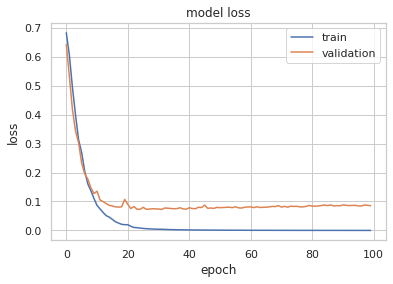

In [127]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

- binary accuracy: proportion of predictions that match labels or response variables
- MSE: measure the accuracy of continuous response variables (e.g. polygenic risk scores, total serum cholesterol level, height, weight, systolic blood pressure)

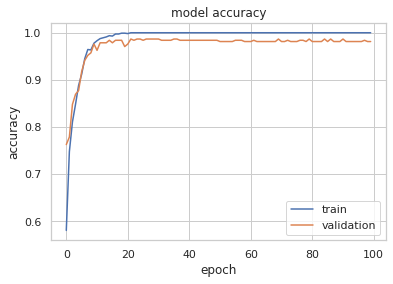

In [128]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


# 3. Evaluate

In [46]:
from sklearn.metrics import confusion_matrix
import itertools

labels_predicted = model.predict(features_test)

Confusion matrix:
 [[251   8]
 [  3 238]]


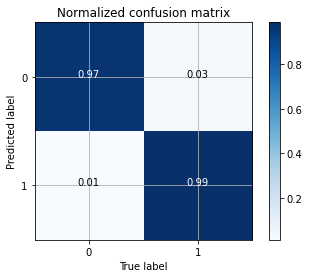

In [47]:
cm = confusion_matrix(np.argmax(labels_test, axis=1), 
                      np.argmax(labels_predicted, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

# 4. Interpret
Compute a saliency map, which is the gradient of the model's prediction wrt each individual nucleotide

- It shows how the output response value changes wrt a small changes in input nucleotide sequence
- +ve values: a small change to that nucleotide will change the output value

In [34]:
import tensorflow.keras.backend as K

def compute_salient_bases(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
  return sal

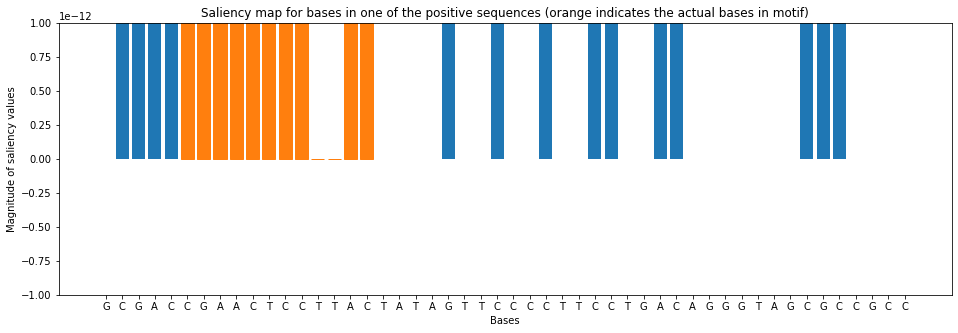

In [51]:
sequence_index = 1567  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(5,17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for bases in one of the positive sequences'
          ' (orange indicates the actual bases in motif)');

In [36]:
#! pip install lazypredict

In [96]:
import lazypredict

In [116]:
clf = lazypredict.Supervised.LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(features_train_2d, features_test_2d, labels_train_vector, labels_test_vector)

100%|██████████| 29/29 [00:04<00:00,  5.89it/s]


In [117]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.80,0.80,None,0.80,0.39
LGBMClassifier,0.79,0.79,None,0.79,0.17
ExtraTreesClassifier,0.75,0.75,None,0.75,0.34
NuSVC,0.74,0.74,None,0.74,0.39
RandomForestClassifier,0.73,0.73,None,0.73,0.43
SVC,0.71,0.71,None,0.71,0.33
AdaBoostClassifier,0.66,0.66,None,0.66,0.24
BernoulliNB,0.66,0.66,None,0.66,0.02
QuadraticDiscriminantAnalysis,0.66,0.66,None,0.66,0.05


In [119]:
predictions

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.80,0.80,None,0.80,0.39
LGBMClassifier,0.79,0.79,None,0.79,0.17
ExtraTreesClassifier,0.75,0.75,None,0.75,0.34
NuSVC,0.74,0.74,None,0.74,0.39
RandomForestClassifier,0.73,0.73,None,0.73,0.43
SVC,0.71,0.71,None,0.71,0.33
AdaBoostClassifier,0.66,0.66,None,0.66,0.24
BernoulliNB,0.66,0.66,None,0.66,0.02
QuadraticDiscriminantAnalysis,0.66,0.66,None,0.66,0.05


[(0.0, 1.0)]

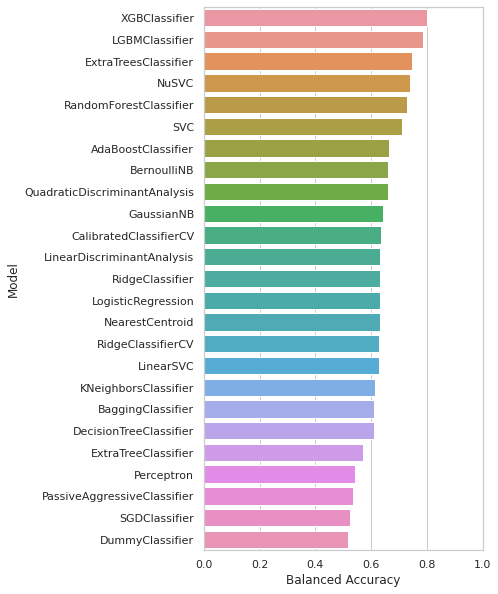

In [122]:
import seaborn as sns
plt.figure(figsize=(5, 10))
sns.set_theme(style='whitegrid')
ax = sns.barplot(y=predictions.index, x='Balanced Accuracy', data=predictions)
ax.set(xlim=(0, 1))

[(0.0, 1.0)]

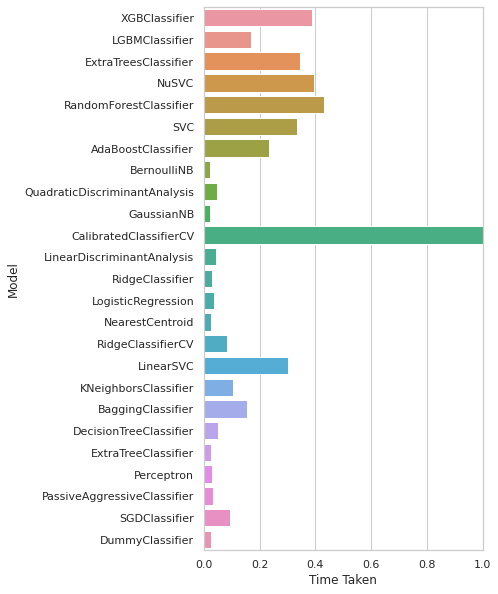

In [123]:
plt.figure(figsize=(5, 10))
sns.set_theme(style='whitegrid')
ax = sns.barplot(y=predictions.index, x='Time Taken', data=predictions)
ax.set(xlim=(0, 1))

In [109]:
y = data.target

In [110]:
y

array([0, 0, 0, ..., 0, 0, 1])

In [111]:
labels

array([['0'],
       ['0'],
       ['0'],
       ...,
       ['0'],
       ['1'],
       ['1']], dtype='<U1')